# Setup

In [3]:
# Import packages
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import pymc3 as pm
import copy
import theano
import theano.tensor as tt
from sklearn.svm import LinearSVC
from sklearn.model_selection import PredefinedSplit, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
# change default plotting
plt.rcParams.update({'font.size': 22, 'figure.figsize': (12,3)})

demo of make_vonmises function:


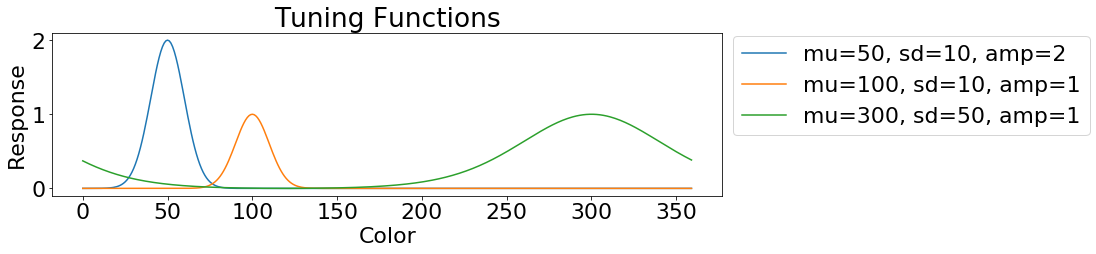

In [4]:
# Convenience functions
k2sd = lambda k : np.sqrt( -2 * np.log( sp.special.iv(1,k) / sp.special.iv(0,k) ) )

def sd2k(S):
    try:
        len(S)
    except:
        S = np.array([S])
    R = np.exp(-S**2/2)
    K = 1/(R**3 - 4 * R**2 + 3 * R)
    if np.any(R < 0.85):
        K[R < 0.85] = -0.4 + 1.39 * R[R < 0.85] + 0.43/(1 - R[R < 0.85])
    if np.any(R < 0.53):
        K[R < 0.53] = 2 * R[R < 0.53] + R[R < 0.53]**3 + (5 * R[R < 0.53]**5)/6
    if len(S) == 1:
        K = float(K)
    return K

def wrap360(a,b):
    try:
        len(a)
    except:
        a = np.array([a]); b= np.array([b])
    diff = np.full(len(a),np.nan)
    for k in np.arange(len(a)):
        diff[k] = b[k] - a[k]
        if diff[k] < -180:
            diff[k] = b[k] - a[k] + 360
        elif diff[k] > 180:
            diff[k] = b[k] - a[k] - 360
    return diff

def within360(y):
    x = copy.deepcopy(y)
    try:
        len(x)
    except:
        x = np.array([x])
    x[x>359] = x[x>359]-360
    x[x<0] = x[x<0]+360
    return x

def within180(y):
    x = copy.deepcopy(y)
    try:
        len(x)
    except:
        x = np.array([x])
    x[x<0] = x[x<0]+360
    x[x>180] = x[x>180]-360
    return np.abs(x)

nchannels=6
def make_vonmises(xx,mu,sd,amp=np.ones(nchannels)/nchannels):
    try:
        try:
            len(amp)
        except:
            amp = np.array([amp])
        res = np.exp(sd2k(np.deg2rad(sd))*np.cos(np.deg2rad(xx-mu)))/(2*np.pi*sp.special.i0(sd2k(np.deg2rad(sd))))
        res[np.isnan(res)] = 0 # if requesting a stick function (very small sd), return a stick function
        if np.all(res==0):
            res[int(np.floor(mu))] = amp[0]
        norm_res = (res - np.min(res)) / (np.max(res) - np.min(res)) 
        return norm_res * amp[0]
    except: # if making multiple tuning functions at once
        res1 = np.full( (360,len(mu)) , np.nan)
        for i in range(len(mu)):
            res = np.exp(sd2k(np.deg2rad(sd[i]))*np.cos(np.deg2rad(xx-mu[i])))/(2*np.pi*sp.special.i0(sd2k(np.deg2rad(sd[i]))))
            res[np.isnan(res)] = 0 
            if np.all(res==0):
                res[int(np.floor(mu[i]))] = amp[i]
            norm_res = (res - np.min(res)) / (np.max(res) - np.min(res)) 
            res1[:,i] = norm_res * amp[i]
        return res1
    
print('demo of make_vonmises function:')
plt.plot(make_vonmises(np.linspace(0,359,360),50,10,2),label="mu=50, sd=10, amp=2")
plt.plot(make_vonmises(np.linspace(0,359,360),100,10,1),label="mu=100, sd=10, amp=1")
plt.plot(make_vonmises(np.linspace(0,359,360),300,50,1),label="mu=300, sd=50, amp=1")
plt.xlabel('Color')
plt.ylabel('Response')
plt.legend(bbox_to_anchor=(1, 1.05))
plt.title("Tuning Functions")
plt.show()

# function to automate neuron/voxel simulation:
def sim_vox(plotting=0):
    # Simulate neurons/voxels
#     trial_features = list(map(int,np.random.choice(feature_space, ntrials)))
    trial_features = np.arange(360)
    trial_conds = np.tile(np.array([0,1]),ntrials//2)
    trial_by_vox = np.full([ntrials,nvoxels], np.nan)
    for vox in np.arange(nvoxels):
        vox_tuning = make_vonmises( 
            np.linspace(0,359,360),
            vox_by_neuron_mu[(vox*nneurons):((vox+1)*nneurons)],
            vox_by_neuron_sd[(vox*nneurons):((vox+1)*nneurons)],
            vox_by_neuron_amp[(vox*nneurons):((vox+1)*nneurons)])
        for trial in np.arange(ntrials):
            neuron_w_noise = vox_tuning[trial_features[trial],:] + (np.random.randn(nneurons)*neuron_noise)
            neuron_w_noise_and_gain = neuron_w_noise * (trial_conds[trial]*vox_gain_diff + 1)
            trial_by_vox[trial,vox] = np.sum(neuron_w_noise_and_gain)
    trial_by_vox = trial_by_vox.clip(min=0)
    if plotting:
        with plt.rc_context(rc={'font.size': 14, 'figure.figsize': (12,1)}):
            plt.hist(vox_mu,bins=30)
            plt.ylabel('Count')
            plt.title("Each voxel's maximal color preference")
            plt.show()
            plt.hist(vox_by_neuron_mu,bins=30)
            plt.ylabel('Count')
            plt.title("Each neuron's maximal color preference")
            plt.show()
            plt.hist(vox_by_neuron_amp,bins=30)
            plt.ylabel('Count')
            plt.title("Each neuron's amplitude if maximal stimulus")
            plt.show()
            plt.hist(vox_by_neuron_sd,bins=30)
            plt.ylabel('Count')
            plt.title("Each neuron's sd of tuning function")
            plt.show()
    return trial_by_vox, np.array(trial_features), trial_conds

# Simulate neurons and voxels

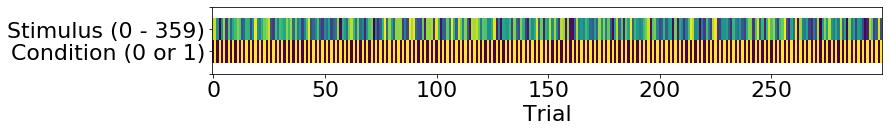

In [12]:
ntrials = 300
nvoxels = 100
nneurons = 100 # voxel activation = sum of nneurons
vox_mu_sd = .01
vox_sd_mu = 5
vox_sd_sd = .01
vox_gain_diff = 0 # difference in amplitude between trial conditions
neuron_noise = 20 # introduce noise for every neuron
feature_space = np.linspace(0,359,360) # full range of our continuous feature (here 360 degrees in color wheel)
trial_features = list(map(int,np.random.choice(feature_space, ntrials))) # feature presented on given trial
trial_conds = np.tile(np.array([0,1]),ntrials//2) # condition of given trial

basis_points = np.linspace(0,360-(360//nchannels),nchannels) # basis set centers
basis_points = list(map(int, basis_points))

# Plotting:
plt.imshow([trial_features,trial_conds*360],aspect=10)
plt.yticks([-1,0,1,2],['','Stimulus (0 - 359)','Condition (0 or 1)',''])
plt.xlabel('Trial')
plt.show()

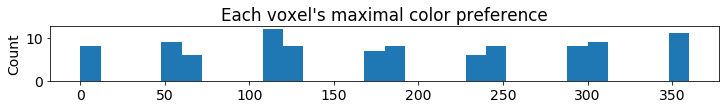

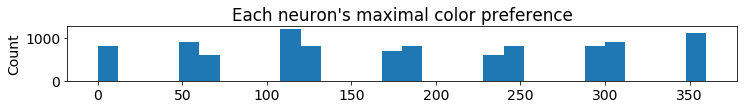

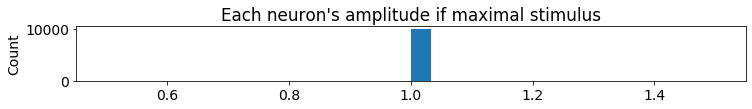

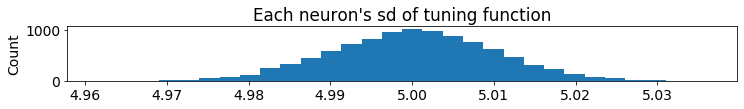

In [13]:
vox_nchannels = 6
vox_mu_basis = np.linspace(0,360-(360//vox_nchannels),vox_nchannels) # ground truth voxel receptive fields
vox_amp_basis = np.ones(vox_nchannels) # amplitude for given features

y_mu = pm.NormalMixture.dist(w=np.ones(vox_nchannels)/vox_nchannels, 
                          mu=vox_mu_basis,
                          sigma=np.ones(vox_nchannels)*vox_mu_sd)
vox_mu = within360(y_mu.random(size=nvoxels))

vox_by_neuron_mu = np.repeat(vox_mu,nneurons)
vox_by_neuron_amp = np.full( (nvoxels*nneurons), np.nan)
for vox in np.arange(nvoxels):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(vox_mu[vox],len(basis_points)),basis_points) ) )
    vox_by_neuron_amp[(vox*nneurons):((vox+1)*nneurons)] = vox_amp_basis[closest_basis]
    
y_sd = pm.TruncatedNormal.dist(mu=vox_sd_mu, sd=vox_sd_sd, lower=0)
vox_by_neuron_sd = y_sd.random(size=(nvoxels*nneurons))

with plt.rc_context(rc={'font.size': 14, 'figure.figsize': (12,1)}):
    plt.hist(vox_mu,bins=30)
    plt.ylabel('Count')
    plt.title("Each voxel's maximal color preference")
    plt.show()
    plt.hist(vox_by_neuron_mu,bins=30)
    plt.ylabel('Count')
    plt.title("Each neuron's maximal color preference")
    plt.show()
    plt.hist(vox_by_neuron_amp,bins=30)
    plt.ylabel('Count')
    plt.title("Each neuron's amplitude if maximal stimulus")
    plt.show()
    plt.hist(vox_by_neuron_sd,bins=30)
    plt.ylabel('Count')
    plt.title("Each neuron's sd of tuning function")
    plt.show()

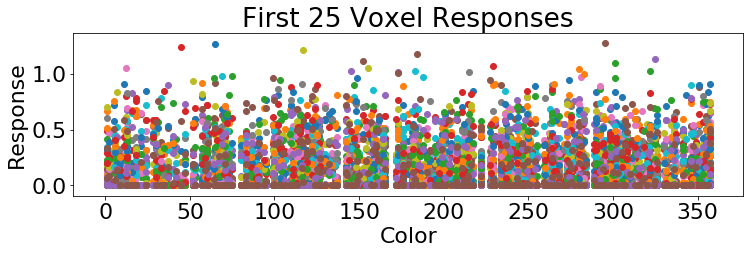

In [14]:
trial_by_vox = np.full([ntrials,nvoxels], np.nan)

for vox in np.arange(nvoxels):
    # for every voxel, we create tuning function across 100 neurons...
    vox_tuning = make_vonmises( 
        np.linspace(0,359,360),
        vox_by_neuron_mu[(vox*nneurons):((vox+1)*nneurons)],
        vox_by_neuron_sd[(vox*nneurons):((vox+1)*nneurons)],
        vox_by_neuron_amp[(vox*nneurons):((vox+1)*nneurons)])
    # we then add random neuron_noise, possible condition-specific amplitude changes, 
    # and then sum across how each neuron responds to each trial's feature for each voxel
    for trial in np.arange(ntrials):
        neuron_w_noise = vox_tuning[trial_features[trial],:] + (np.random.randn(nneurons)*neuron_noise)
        neuron_w_noise_and_gain = neuron_w_noise * (trial_conds[trial]*vox_gain_diff + 1)
        trial_by_vox[trial,vox] = np.sum(neuron_w_noise_and_gain)
trial_by_vox = trial_by_vox.clip(min=0)

for vox in np.arange(nvoxels):
    if vox <= 25:
        plt.scatter(trial_features,trial_by_vox[:,vox])
plt.xlabel('Color')
plt.ylabel('Response')
plt.yticks([0,np.max(trial_by_vox[:,vox])//2,np.max(trial_by_vox[:,vox])], [0.0,0.5,1.0])
plt.title('First 25 Voxel Responses')
plt.show()

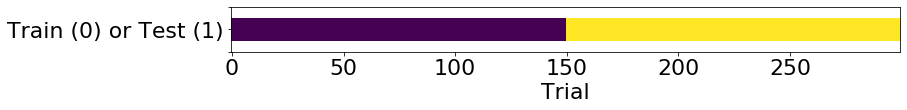

In [15]:
# Define training/testing trials
trn = trial_by_vox[:ntrials//2,:] # training: trial "Betas"
trnf = np.array(trial_features[:ntrials//2]) # training trial features
tst = trial_by_vox[ntrials//2:,:] # testing: trial "Betas"
tstf = np.array(trial_features[ntrials//2:]) # test trial features
trn_or_tst = np.hstack((np.full( len(trn) , 0), np.full( len(tst) , 1)))

# Plotting:
plt.imshow([trn_or_tst*360],aspect=10)
plt.yticks([-1,0,1],['','Train (0) or Test (1)',''])
plt.xlabel('Trial')
plt.show()

# Inverted Encoding Model

## Create Forward Model & Design Matrix

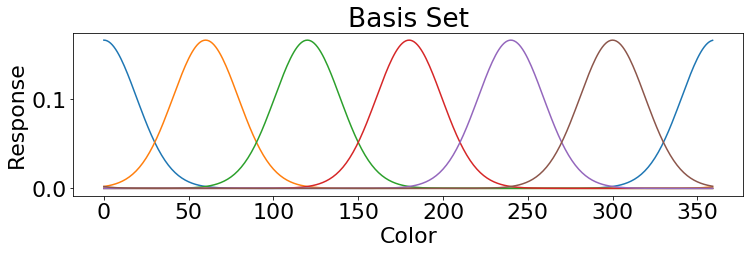

In [16]:
nchannels = 6
channel_sd = np.ones(nchannels)*20 # standard deviation of each basis
    
# create each basis channel
basis_set = make_vonmises(feature_space, basis_points, channel_sd)

# plot basis functions
for chan in np.arange(nchannels):
    plt.plot(basis_set[:,chan])

plt.xlabel('Color')
plt.ylabel('Response')
plt.title("Basis Set")
plt.show()

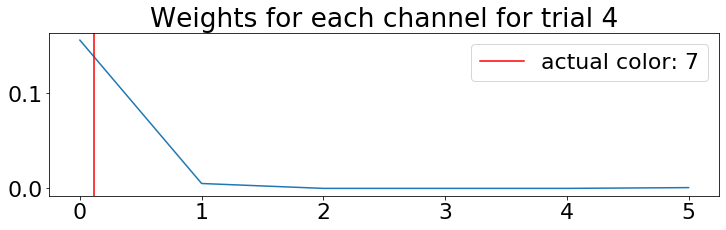

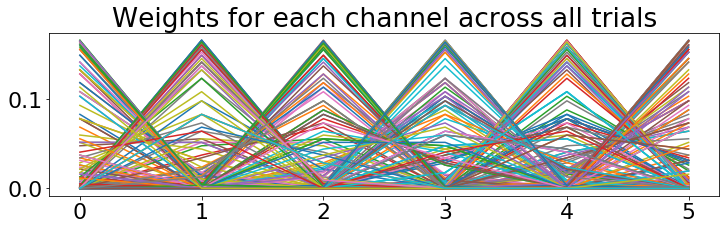

In [17]:
trial_weights = basis_set[trial_features,:]

trial = 3
plt.plot(trial_weights[trial,:])
plt.title("Weights for each channel for trial {}".format(trial+1))
plt.axvline(trial_features[trial]/360 * nchannels,color='red',label="actual color: {}".format(trial_features[trial]))
plt.legend()
plt.show()

for trial in np.arange(ntrials):
    plt.plot(trial_weights[trial,:])
plt.title('Weights for each channel across all trials')
plt.show()

## Test if channels are linearly dependent
Test to see if we have a full rank design matrix (tests if channels are linearly dependent). Linearly dependent channels are bad because it means that at least one of the channels can be defined as a linear combination of the others. This is bad because then we can't uniquely estimate the contribution of each channel to the signal observed in a given voxel. In other words, if trail_weights is not full rank then we have effectively lost the contribution of at least one of the nchannel dimensions.

In [18]:
print('Design matrix: rank = {}'.format( np.linalg.matrix_rank(trial_weights) ))
if np.linalg.matrix_rank(trial_weights) != nchannels:
    raise Exception('trial_weights not full rank')

Design matrix: rank = 6


## Compute weights of forward model

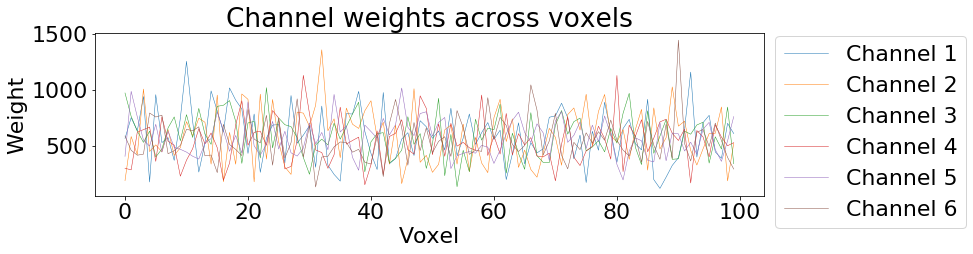

In [19]:
channelweights_per_vox = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trn, rcond=None)[0] 
# solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

vox_idx = np.argmin(channelweights_per_vox[0,:])

for chan in range(nchannels):
    plt.plot(channelweights_per_vox[chan,:].T,linewidth=.5,label="Channel " + str(chan+1));
plt.title('Channel weights across voxels');
plt.xlabel("Voxel")
plt.ylabel("Weight")
plt.legend(bbox_to_anchor=(1, 1.05))

## Invert to compute channel responses

In [20]:
cr_trn = np.linalg.lstsq(channelweights_per_vox.T , trn.T, rcond=None)[0].T
cr_tst = np.linalg.lstsq(channelweights_per_vox.T , tst.T, rcond=None)[0].T

### Reconstruct training data (note: this is circular, it should be near-perfect!)

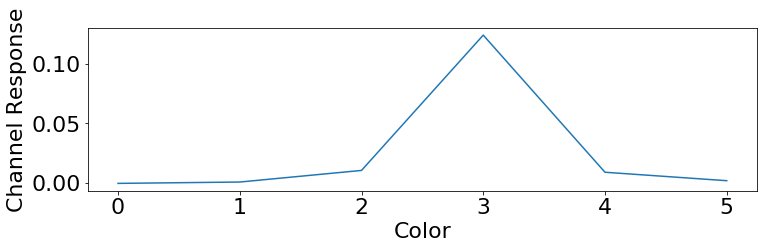

MAE: 35.95333333333333


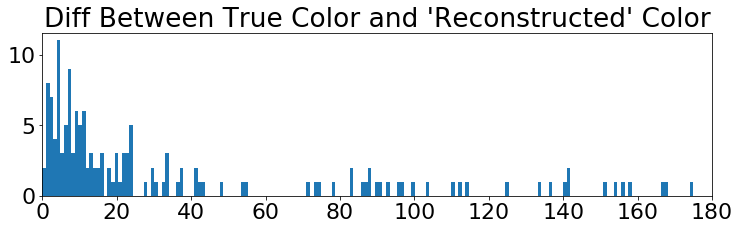

In [21]:
cr_center_trn = np.empty_like(cr_trn)
estimated_color = np.full(cr_center_trn.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_trn.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(trnf[trial],len(basis_points)), basis_points) ) )
    cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - closest_basis );
    estimated_color[trial] = basis_points[np.argmax(cr_trn[trial,:])]
    
plt.plot(np.mean(cr_center_trn,axis=0))
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.show()

plt.hist(np.abs(wrap360(estimated_color, trnf)), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")

trn_mae = np.mean(np.abs(wrap360(estimated_color, trnf)))
print("MAE: {}".format(trn_mae))

### Reconstruct test data

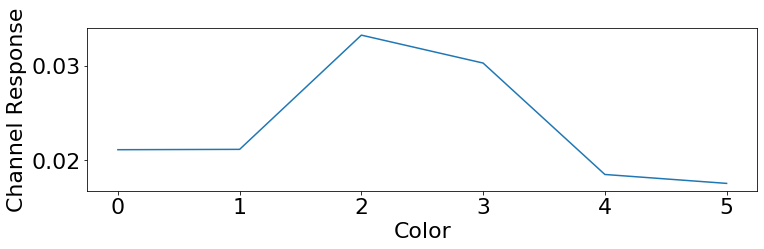

MAE: 79.67333333333333


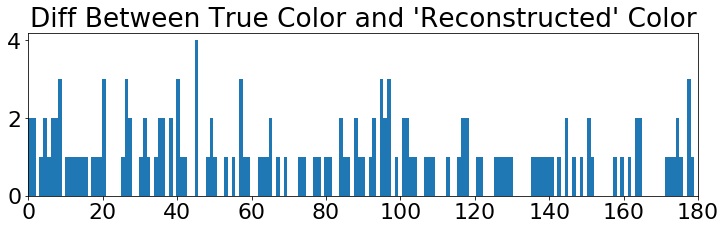

In [22]:
cr_center_tst = np.empty_like(cr_tst)
estimated_color = np.full(cr_center_tst.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_tst.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(tstf[trial],len(basis_points)), basis_points) ) )
    cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - closest_basis );
    estimated_color[trial] = basis_points[np.argmax(cr_tst[trial,:])]
    
plt.plot(np.mean(cr_center_tst,axis=0))
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.show()

plt.hist(np.abs(wrap360(estimated_color, tstf)), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")

tst_mae = np.mean(np.abs(wrap360(estimated_color, tstf)))
print("MAE: {}".format(tst_mae))

### Null Distribution / Significance Test

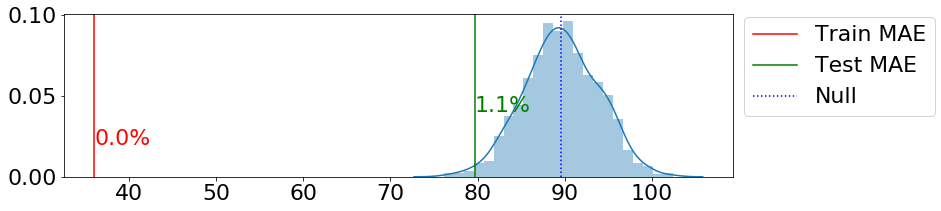

Model performance: 9.960146666666667


In [23]:
# Reconstruct the stimulus:
estimated_color = np.full(cr_tst.shape[0],np.nan)
null_mae = np.full(1000,np.nan)
for perm in np.arange(1000):
    shuffled_tst = np.random.permutation(tst)
    cr_shuffle_tst = np.linalg.lstsq(channelweights_per_vox.T , shuffled_tst.T, rcond=None)[0].T
    for trial in np.arange(cr_shuffle_tst.shape[0]):
        estimated_color[trial] = basis_points[np.argmax(cr_shuffle_tst[trial,:])]

    null_mae[perm] = np.mean(np.abs(wrap360(estimated_color, tstf)))

trn_overlap = len(null_mae[null_mae<trn_mae])/len(null_mae) * 100
tst_overlap = len(null_mae[null_mae<tst_mae])/len(null_mae) * 100

sns.distplot(null_mae)
plt.axvline(trn_mae,color='red',label="Train MAE")
plt.axvline(tst_mae,color='green',label="Test MAE")
plt.axvline(np.mean(null_mae),linestyle=':',color='blue',label="Null")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.text(trn_mae,.02,"{:.1f}%".format(trn_overlap),color='red')
plt.text(tst_mae,.04,"{:.1f}%".format(tst_overlap),color='green')
plt.show()

print("Model performance: {}".format(np.mean(null_mae - tst_mae)))

# Automate simulations
## Function to perform IEM on simulated data

In [187]:
def auto_recon(basis_points,channel_sd,trial_features,trial_by_vox,n_splits=2,plotting=0):   
    # create each basis channel
    basis_set = make_vonmises(feature_space, basis_points, channel_sd)
    trial_weights = basis_set[trial_features,:]
    
    # prep cross-validation, assign trials as training or test data
    kf = KFold(n_splits=n_splits, shuffle=True) 
    X = np.linspace(0,ntrials-1,np.sum(ntrials)) 
    kf.get_n_splits(X);

    cv_iter = -1
    for train_index, test_index in kf.split(X):
        if cv_iter == -1:
            if plotting:
                cr_trn = np.full((n_splits,len(train_index),nchannels),np.nan)
            cr_tst = np.full((n_splits,len(test_index),nchannels),np.nan)
            saved_weights = np.full((n_splits,nchannels,trial_by_vox.shape[1]),np.nan)
        cv_iter = cv_iter + 1

        trn = trial_by_vox[train_index,:]
        tst = trial_by_vox[test_index,:]

        trnf = trial_features[train_index]
        tstf = trial_features[test_index]
        trn_or_tst = np.zeros(len(trial_features))
        trn_or_tst[test_index] = 1

        saved_weights[cv_iter,:] = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trn, rcond=None)[0] 
        # solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

        # Invert to compute channel responses
        if plotting:
            cr_trn[cv_iter,:,:] = np.linalg.lstsq(saved_weights[cv_iter,:,:].T , trn.T, rcond=None)[0].T
        cr_tst[cv_iter,:,:] = np.linalg.lstsq(saved_weights[cv_iter,:,:].T , tst.T, rcond=None)[0].T

    # average folds
    if plotting:
        cr_trn = np.mean(cr_trn[:,:,:],axis=0)
    cr_tst = np.mean(cr_tst[:,:,:],axis=0)
    saved_weights = np.mean(saved_weights[:,:,:],axis=0)
    #full_saved_weights = np.linalg.lstsq(trial_weights, trial_by_vox, rcond=None)[0] 

    # Plot perfect reconstruction for comparison
    shiftby = nchannels//2
    perfect_recon = trial_weights[np.where(trial_features==shiftby*(360/nchannels))[0][0],:]

    # Avg. reconstructions (training)
    if plotting:
        cr_center_trn = np.empty_like(cr_trn)
        trial_actual = np.full(cr_trn.shape[0],999)
        trial_guess = np.full(cr_trn.shape[0],999)
        for trial in np.arange(cr_trn.shape[0]):
            trial_actual[trial] = int(trnf[trial]/(360/nchannels))
            trial_guess[trial] = np.argmax(cr_trn[trial,:])
            cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - trial_actual[trial]);
        trial_diff = np.abs(trial_actual-trial_guess)
        trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
        trial_diff = perfect_recon[shiftby]-np.roll(perfect_recon,shiftby)[trial_diff]
        trn_mae = np.mean(trial_diff)

    # Avg. reconstructions (testing)
    cr_center_tst = np.empty_like(cr_tst)
    trial_actual = np.full(cr_tst.shape[0],999)
    trial_guess = np.full(cr_tst.shape[0],999)
    for trial in np.arange(cr_tst.shape[0]):
        trial_actual[trial] = int(tstf[trial]/(360/nchannels))
        trial_guess[trial] = np.argmax(cr_tst[trial,:])
        cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
    trial_diff = np.abs(trial_actual-trial_guess)
    trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
    trial_diff = perfect_recon[shiftby]-np.roll(perfect_recon,shiftby)[trial_diff]
    tst_mae = np.mean(trial_diff)

    if plotting:
        # Null distribution testing
        numperms = 1000
        cr_center_null = np.empty_like(cr_tst)
        trial_actual = np.full(cr_tst.shape[0],999)
        trial_guess = np.full(cr_tst.shape[0],999)
        null_mae = np.full(numperms,np.nan)
        for perm in np.arange(numperms):
            tstf_shuffle = np.random.permutation(tstf)
            for trial in np.arange(cr_tst.shape[0]):
                trial_actual[trial] = int(tstf_shuffle[trial]/(360/nchannels))
                trial_guess[trial] = np.argmax(cr_tst[trial,:])
                cr_center_null[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
            trial_diff = np.abs(trial_actual-trial_guess)
            trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
            trial_diff = perfect_recon[shiftby]-np.roll(perfect_recon,shiftby)[trial_diff]
            null_mae[perm] = np.mean(trial_diff)

    if plotting:
        trn_overlap = len(null_mae[null_mae<trn_mae])/len(null_mae)*100
        tst_overlap = len(null_mae[null_mae<tst_mae])/len(null_mae)*100

    if plotting:
        print("Reconstructions aligned at {} \n".format(shiftby))
        plt.plot(perfect_recon,color='k')
        plt.title("Perfect Reconstruction (for comparison)")
        plt.xlabel("Color")
        plt.ylabel("Channel Response")
        plt.show()
        plt.plot(np.mean(cr_center_trn,axis=0),color='b')
        plt.title("Train")
        plt.xlabel("Color")
        plt.ylabel("Channel Response")
        plt.show()
        print("train: avg MAE: {}".format(trn_mae))
        plt.plot(np.mean(cr_center_tst,axis=0),color='r')
        plt.title("Test")
        plt.xlabel("Color")
        plt.ylabel("Channel Response")
        plt.show()    
        plt.plot(np.mean(cr_center_trn,axis=0),color='b',label="Train")
        plt.plot(np.mean(cr_center_tst,axis=0),color='r',label="Test")
        plt.plot(np.mean(cr_center_null,axis=0),color='gray',label="Null")
        plt.title("All Reconstructions (overlaid)")
        plt.xlabel("Color")
        plt.ylabel("Channel Response")
        plt.legend()
        plt.show()
        print("test: avg MAE: {}".format(tst_mae))
        sns.distplot(null_mae,color='gray',bins=10)
        plt.axvline(trn_mae,color='blue',label="Train MAE")
        plt.axvline(tst_mae,color='red',label="Test MAE")
        plt.axvline(np.mean(null_mae),linestyle=':',color='gray',label="Null")
        plt.legend(bbox_to_anchor=(1, 1.05))
        plt.text(trn_mae,1,"{:.2f}%".format(trn_overlap),color='blue')
        plt.text(tst_mae,.25,"{:.2f}%".format(tst_overlap),color='red')
        plt.xlim([0,1])
        plt.show()
        print("null: avg MAE: {}".format(np.mean(null_mae)))
        print("% overlap w/ null distribution ({} permutations): {}%".format(numperms,tst_overlap))
        print("basically, this means p={:.3f}".format(tst_overlap/100))
        if tst_overlap < 5:
            print("meaning that test reconstructions are significantly different from null reconstructions!")
        else:
            print("meaning that test reconstructions are not significantly different from null reconstructions.")
        # Plot simulated voxel tunings:               
        plt.plot(make_vonmises(np.linspace(0,359,360),vox_mu_basis,np.ones(nchannels)*vox_sd_mu,vox_amp_basis))
        plt.title('Underlying voxel basis (ground truth)') 
        plt.ylabel('Response')
        plt.xlabel('Color')
        plt.yticks([])
        plt.show()
        return saved_weights, tst_overlap
    else:
        return tst_mae
    
def plot_basis_avg(basis_points,channel_sd,trial_features,chan_pow=np.ones(nchannels)/nchannels): 
    # reset default matplotlib color picker
    plt.gca().set_prop_cycle(None)
    
    # create each basis channel
    basis_set = make_vonmises(feature_space, basis_points, channel_sd, chan_pow)
        
    # plot basis functions
    for chan in np.arange(nchannels):
        plt.plot(basis_set[:,chan])

    plt.xlabel('Color')
    plt.ylabel('Response')
    plt.yticks([])
    plt.title("Reconstructed Basis Set",color='green') 
    
def plot_basis_dotted(basis_points,channel_sd,trial_features,chan_pow=np.ones(nchannels)/nchannels): 
    # reset default matplotlib color picker
    plt.gca().set_prop_cycle(None)
    
    # create each basis channel
    basis_set = make_vonmises(feature_space, basis_points, channel_sd, chan_pow)
        
    # plot basis functions
    for chan in np.arange(nchannels):
        plt.plot(basis_set[:,chan],':')

## Simulation of data in one cell

In [267]:
ntrials = 360*2
nvoxels = 100
nneurons = 2 # voxel activation = sum of nneurons
vox_mu_sd = 1
vox_sd_mu = 15
vox_sd_sd = 1
vox_gain_diff = 0 # difference in amplitude between trial conditions
neuron_noise = 3 # introduce noise for every neuron
feature_space = np.linspace(0,359,360) # full range of our continuous feature (here 360 degrees in color wheel)

nchannels = 6
vox_nchannels = 6
vox_mu_basis = np.linspace(0,360-(360//vox_nchannels),vox_nchannels)+10 # ground truth voxel receptive fields
basis_points = vox_mu_basis
vox_amp_basis = np.ones(vox_nchannels) # amplitude for given features

# randomize the amplitudes of the vox basis set
y_amp = pm.Dirichlet.dist(a=np.ones(nchannels)/nchannels)
vox_amp_basis = np.mean(y_amp.random(size=25),axis=0) * nchannels

y_mu = pm.NormalMixture.dist(w=np.ones(vox_nchannels)/vox_nchannels, 
                          mu=vox_mu_basis,
                          sigma=np.ones(vox_nchannels)*vox_mu_sd)
vox_mu = within360(y_mu.random(size=nvoxels))

vox_by_neuron_mu = np.repeat(vox_mu,nneurons)
vox_by_neuron_amp = np.full( (nvoxels*nneurons), np.nan)

for vox in np.arange(nvoxels):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(vox_mu[vox],len(basis_points)),basis_points) ) )
    vox_by_neuron_amp[(vox*nneurons):((vox+1)*nneurons)] = vox_amp_basis[closest_basis]
    
y_sd = pm.TruncatedNormal.dist(mu=vox_sd_mu, sd=vox_sd_sd, lower=0)
vox_by_neuron_sd = y_sd.random(size=(nvoxels*nneurons))

trial_by_vox, trial_features, trial_conds = sim_vox(plotting=1)

saved_weights, tst_overlap = auto_recon(basis_points,channel_sd,trial_features,trial_by_vox,plotting=1)

plot_basis_avg(basis_points,channel_sd,trial_features,np.mean(saved_weights,axis=1))

INFO (theano.gof.compilelock): Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock


KeyboardInterrupt: 

# MCMC Fitting: Find the optimal basis set
## Find optimal shifting of basis sets

In [191]:
class LogLike0(tt.Op):
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value
    
    def __init__(self, function, basis_points, channel_sd, trial_features, trial_by_vox):

        # add inputs as class attributes
        self.likelihood = function
        self.basis_points = basis_points
        self.channel_sd = channel_sd
        self.trial_features = trial_features
        self.trial_by_vox = trial_by_vox
        
        # initialise the gradient Op (below)
        self.logpgrad = LogLikeGrad(self.likelihood, self.basis_points, self.channel_sd,
                                   self.trial_features, self.trial_by_vox)

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta, = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta, self.basis_points, self.channel_sd,
                              self.trial_features, self.trial_by_vox)

        outputs[0][0] = np.array(logl) # output the log-likelihood

class LogLike(tt.Op):
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value
    
    def __init__(self, function, basis_points, channel_sd, trial_features, trial_by_vox):

        # add inputs as class attributes
        self.likelihood = function
        self.basis_points = basis_points
        self.channel_sd = channel_sd
        self.trial_features = trial_features
        self.trial_by_vox = trial_by_vox
        
        # initialise the gradient Op (below)
        self.logpgrad = LogLikeGrad(self.likelihood, self.basis_points, self.channel_sd,
                                   self.trial_features, self.trial_by_vox)

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta, = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta, self.basis_points, self.channel_sd,
                              self.trial_features, self.trial_by_vox)

        outputs[0][0] = np.array(logl) # output the log-likelihood
        
    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        theta, = inputs  # our parameters
        return [g[0]*self.logpgrad(theta)]
    
class LogLikeGrad(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, function, basis_points, channel_sd, trial_features, trial_by_vox):

        # add inputs as class attributes
        self.likelihood = function
        self.basis_points = basis_points
        self.channel_sd = channel_sd
        self.trial_features = trial_features
        self.trial_by_vox = trial_by_vox

    def perform(self, node, inputs, outputs):
        theta, = inputs

        # define version of likelihood function to pass to derivative function
        def lnlike(values):
            return self.likelihood(values, self.basis_points, self.channel_sd,
                                  self.trial_features, self.trial_by_vox)

        # calculate gradients
        grads = gradients(theta, lnlike)

        outputs[0][0] = grads

def gradients(vals, func, releps=1e-3, abseps=None, mineps=1e-9, reltol=1e-3,
              epsscale=0.5):
    """
    Calculate the partial derivatives of a function at a set of values. The
    derivatives are calculated using the central difference, using an iterative
    method to check that the values converge as step size decreases.

    Parameters
    ----------
    vals: array_like
        A set of values, that are passed to a function, at which to calculate
        the gradient of that function
    func:
        A function that takes in an array of values.
    releps: float, array_like, 1e-3
        The initial relative step size for calculating the derivative.
    abseps: float, array_like, None
        The initial absolute step size for calculating the derivative.
        This overrides `releps` if set.
        `releps` is set then that is used.
    mineps: float, 1e-9
        The minimum relative step size at which to stop iterations if no
        convergence is achieved.
    epsscale: float, 0.5
        The factor by which releps if scaled in each iteration.

    Returns
    -------
    grads: array_like
        An array of gradients for each non-fixed value.
    """

    grads = np.zeros(len(vals))

    # maximum number of times the gradient can change sign
    flipflopmax = 10.

    # set steps
    if abseps is None:
        if isinstance(releps, float):
            eps = np.abs(vals)*releps
            eps[eps == 0.] = releps  # if any values are zero set eps to releps
            teps = releps*np.ones(len(vals))
        elif isinstance(releps, (list, np.ndarray)):
            if len(releps) != len(vals):
                raise ValueError("Problem with input relative step sizes")
            eps = np.multiply(np.abs(vals), releps)
            eps[eps == 0.] = np.array(releps)[eps == 0.]
            teps = releps
        else:
            raise RuntimeError("Relative step sizes are not a recognised type!")
    else:
        if isinstance(abseps, float):
            eps = abseps*np.ones(len(vals))
        elif isinstance(abseps, (list, np.ndarray)):
            if len(abseps) != len(vals):
                raise ValueError("Problem with input absolute step sizes")
            eps = np.array(abseps)
        else:
            raise RuntimeError("Absolute step sizes are not a recognised type!")
        teps = eps

    # for each value in vals calculate the gradient
    count = 0
    for i in range(len(vals)):
        # initial parameter diffs
        leps = eps[i]
        cureps = teps[i]

        flipflop = 0

        # get central finite difference
        fvals = np.copy(vals)
        bvals = np.copy(vals)

        # central difference
        fvals[i] += 0.5*leps  # change forwards distance to half eps
        bvals[i] -= 0.5*leps  # change backwards distance to half eps
        cdiff = (func(fvals)-func(bvals))/leps

        while 1:
            fvals[i] -= 0.5*leps  # remove old step
            bvals[i] += 0.5*leps

            # change the difference by a factor of two
            cureps *= epsscale
            if cureps < mineps or flipflop > flipflopmax:
                # if no convergence set flat derivative (TODO: check if there is a better thing to do instead)
                warnings.warn("Derivative calculation did not converge: setting flat derivative.")
                grads[count] = 0.
                break
            leps *= epsscale

            # central difference
            fvals[i] += 0.5*leps  # change forwards distance to half eps
            bvals[i] -= 0.5*leps  # change backwards distance to half eps
            cdiffnew = (func(fvals)-func(bvals))/leps

            if cdiffnew == cdiff:
                grads[count] = cdiff
                break

            # check whether previous diff and current diff are the same within reltol
            rat = (cdiff/cdiffnew)
            if np.isfinite(rat) and rat > 0.:
                # gradient has not changed sign
                if np.abs(1.-rat) < reltol:
                    grads[count] = cdiffnew
                    break
                else:
                    cdiff = cdiffnew
                    continue
            else:
                cdiff = cdiffnew
                flipflop += 1
                continue

        count += 1

    return grads

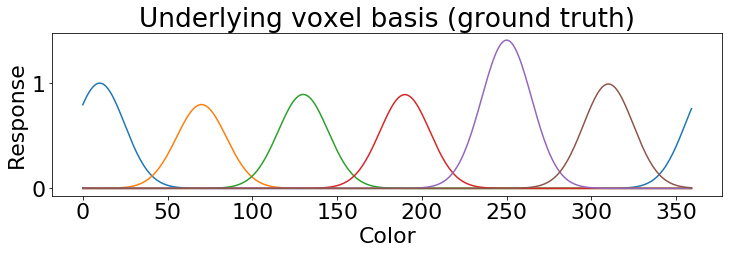

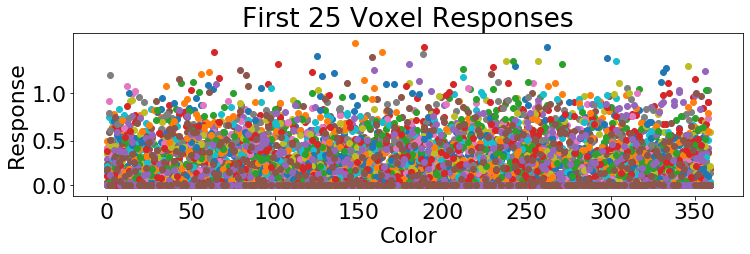

In [189]:
# Plot simulated voxel tunings:               
plt.plot(make_vonmises(np.linspace(0,359,360),vox_mu_basis,np.ones(nchannels)*vox_sd_mu,vox_amp_basis))
plt.title('Underlying voxel basis (ground truth)') 
plt.ylabel('Response')
plt.xlabel('Color')
plt.show()

# Plot actual voxel tunings:
for vox in np.arange(nvoxels):
    if vox <= 25:
        plt.scatter(trial_features,trial_by_vox[:,vox])
plt.xlabel('Color')
plt.ylabel('Response')
plt.yticks([0,np.max(trial_by_vox[:,vox])//2,np.max(trial_by_vox[:,vox])], [0.0,0.5,1.0])
plt.title('First 25 Voxel Responses')
plt.show()

In [227]:
# setup parameter priors
basis_points = np.linspace(0,360-(360//nchannels),nchannels)
true_sh = vox_mu_basis - basis_points

def pseudo_loglike(theta,basis_points,channel_sd,trial_features,trial_by_vox):
    sh = theta
    overlap = auto_recon(basis_points+sh,np.ones(nchannels)*vox_sd_mu,trial_features,trial_by_vox)
    #print(-overlap**2, sh)
    return -overlap**2

# create our Op
logl = LogLike0(pseudo_loglike,basis_points,channel_sd,trial_features,trial_by_vox)

# fit the model
with pm.Model():
    # Priors
    sh_p = pm.Uniform('sh_p', lower=0., upper=(360/nchannels)/2)
    sigma_p = pm.Exponential('sigma_p',1)
    
    for chan in np.arange(nchannels):
        locals()['sh{}'.format(chan)] = pm.Normal('sh{}'.format(chan),
                                                   mu=sh_p,sigma=sigma_p)
    
    # convert to a tensor vector
    theta = tt.as_tensor_variable([sh0,sh1,sh2,sh3,sh4,sh5])
    
    # use a custom blackbox function (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})

    trace = pm.sample(300, tune=500, chains=2)

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sigma_p, sh_p]
>CompoundStep
>>Slice: [sh5]
>>Slice: [sh4]
>>Slice: [sh3]
>>Slice: [sh2]
>>Slice: [sh1]
>>Slice: [sh0]
Sampling 2 chains: 100%|██████████| 1600/1600 [26:57<00:00,  1.01s/draws] 
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.49637091499778346, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sh0,13.197155,9.747334,0.955590,0.343479,30.259836,2.844600,1.441173
sh1,13.269430,9.686045,0.949650,0.406255,30.114271,2.729973,1.460945
sh2,13.084426,9.620665,0.947729,0.453868,29.979389,2.686756,1.468081
sh3,13.081458,9.663806,0.949295,0.521655,30.019344,2.754576,1.457030
sh4,13.257555,9.765212,0.960058,0.296858,30.041675,2.695180,1.463157
sh5,13.302021,9.542136,0.936039,0.190161,29.967465,2.463282,1.505012
sh_p,13.253392,9.511859,0.946706,0.666671,29.888223,2.553072,1.499525
sigma_p,1.495471,1.128546,0.102554,0.079594,3.789181,10.849467,1.080086


ground truth basis MAE:  0.031227101385171867
model-fitted basis MAE:  0.02679425839001591
true sh: [10. 10. 10. 10. 10. 10.]

Reconstructions aligned at 3 



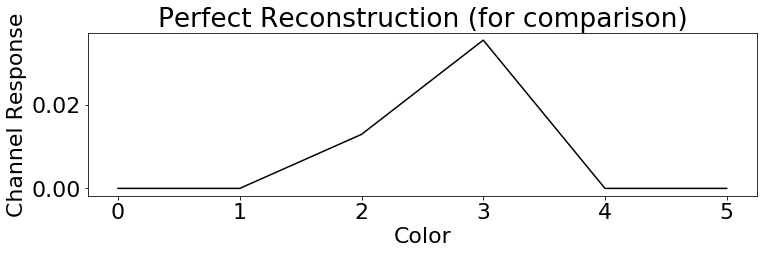

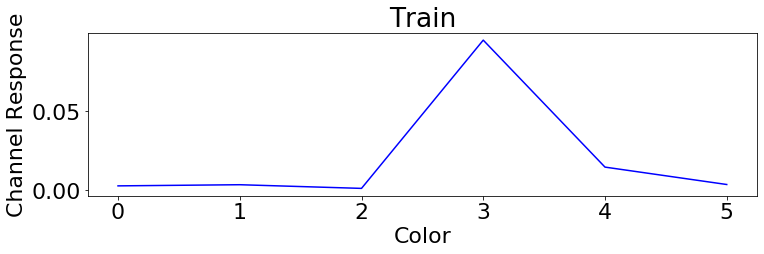

train: avg MAE: 0.008668726255999877


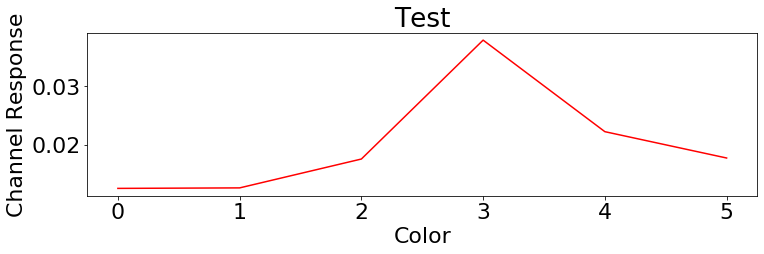

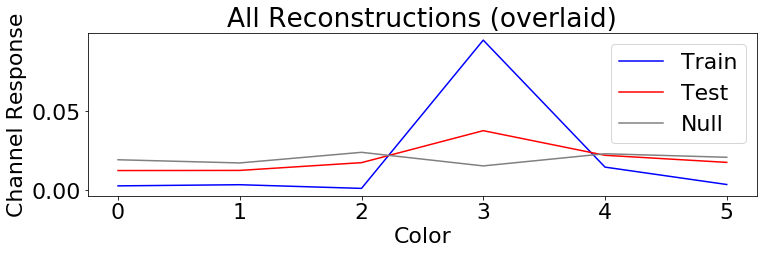

test: avg MAE: 0.022459889828329895


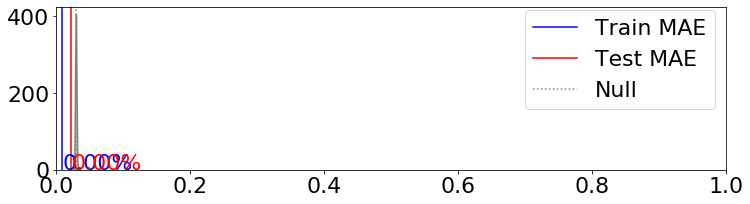

null: avg MAE: 0.02963149605542961
% overlap w/ null distribution (1000 permutations): 0.0%
basically, this means p=0.000
meaning that test reconstructions are significantly different from null reconstructions!


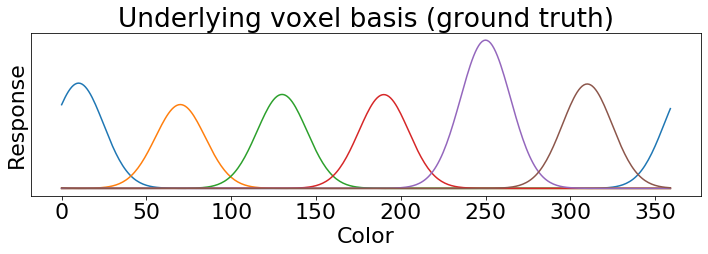

Highest amp to lowest amp channel (ground truth): [4 0 5 2 3 1]
Highest amp to lowest amp channel (reconstructed): [4 0 3 5 1 2]


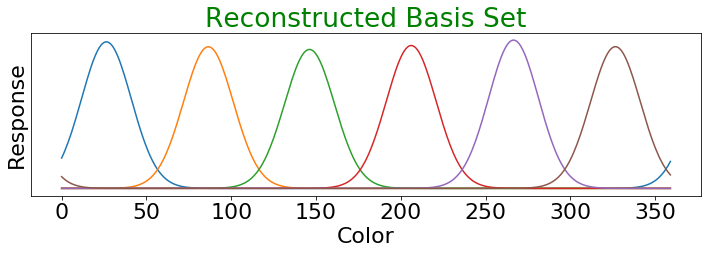

In [231]:
# output results
display(pm.summary(trace))

print('ground truth basis MAE: ', auto_recon(basis_points+true_sh,np.ones(nchannels)*vox_sd_mu,trial_features,trial_by_vox))
print('model-fitted basis MAE: ', auto_recon(basis_points+[np.mean(trace['sh0']),np.mean(trace['sh1']),np.mean(trace['sh2']),np.mean(trace['sh3']),np.mean(trace['sh4']),np.mean(trace['sh5'])],np.ones(nchannels)*vox_sd_mu,trial_features,trial_by_vox))
print('true sh: {}\n'.format(true_sh))

basis_points = basis_points+[np.mean(trace['sh0']),np.mean(trace['sh1']),np.mean(trace['sh2']),np.mean(trace['sh3']),np.mean(trace['sh4']),np.mean(trace['sh5'])]
channel_sd = np.ones(nchannels)*vox_sd_mu
saved_weights, tst_overlap = auto_recon(basis_points,channel_sd,trial_features,trial_by_vox,plotting=1)

plot_basis_avg(basis_points,channel_sd,trial_features,np.mean(saved_weights,axis=1))
print("Highest amp to lowest amp channel (ground truth): {}".format(np.argsort(-vox_amp_basis)))
print("Highest amp to lowest amp channel (reconstructed): {}".format(np.argsort(-np.mean(saved_weights,axis=1))))

## Find optimal shifting, bandwidths, and amplitudes

In [180]:
# setup parameter priors
basis_points = np.linspace(0,360-(360//nchannels),nchannels)
true_sh = vox_mu_basis - basis_points
true_sd = np.ones(nchannels)*vox_sd_mu

def pseudo_loglike(theta,basis_points,channel_sd,trial_features,trial_by_vox):
    sh = theta[0:nchannels]
    sd = theta[nchannels:]
    err, chan_weights = auto_recon(basis_points+sh,sd,trial_features,trial_by_vox)
    return -(err**4)

# create our Op
logl = LogLike0(pseudo_loglike,basis_points,channel_sd,trial_features,trial_by_vox)

# fit the model
with pm.Model():
    # Priors
    sh_p = pm.Uniform('sh_p', lower=0., upper=(360/nchannels)/2)
    sd_p = pm.TruncatedNormal('sd_p', mu=30., sigma=20., lower=5.)
    
    sh_sigma_p = pm.Exponential('sh_sigma_p',1)
    sd_sigma_p = pm.Exponential('sd_sigma_p',1)
    
    for chan in np.arange(nchannels):
        locals()['sh{}'.format(chan)] = pm.Normal('sh{}'.format(chan),
                                                   mu=sh_p,sigma=sh_sigma_p)
        locals()['sd{}'.format(chan)] = pm.TruncatedNormal('sd{}'.format(chan),
                                           mu=sd_p,sigma=sd_sigma_p)
    
    # convert to a tensor vector
    theta = tt.as_tensor_variable([sh0,sh1,sh2,sh3,sh4,sh5,
                                   sd0,sd1,sd2,sd3,sd4,sd5])
    
    # use a custom blackbox function (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})

    trace = pm.sample(200, tune=300, chains=2)

KeyboardInterrupt: 

# Compare With MVPA

Let's say we want to decode (e.g., classify) whether there is signal in our ROI that is different for conditions 1 and 2. Given all the voxels we have from half our dataset, can we decode above chance whether a trial was condition 1 or 2?

In [118]:
trn = trial_by_vox[:ntrials//2,:]
trn_cond = trial_conds[:ntrials//2]
trnf = trial_features[:ntrials//2]

tst = trial_by_vox[ntrials//2:,:]
tst_cond = trial_conds[ntrials//2:]
tstf = trial_features[ntrials//2:]

normalizer = StandardScaler()
trn = normalizer.fit_transform(trn)
tst = normalizer.fit_transform(tst)

In [119]:
model = LinearSVC(C=1)

model.fit(trn, trn_cond)

score = model.score(tst, tst_cond)
print('Accuracy = {}'.format(score))
print('Chance = 0.50')

Accuracy = 0.5133333333333333
Chance = 0.50


What if we want to decode the actual color?

MAE: 63.38666666666666


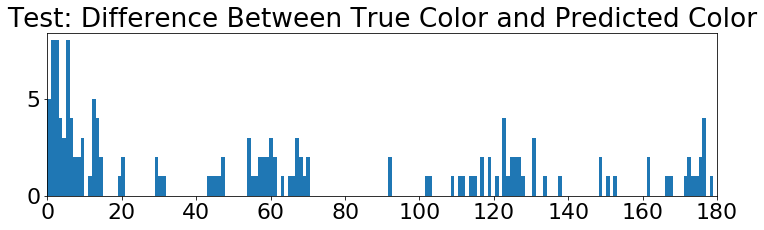

In [122]:
model.fit(trn, trnf)

predictions = model.predict(tst)

plt.hist(np.abs(wrap360(predictions, tstf)), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Test: Difference Between True Color and Predicted Color")

tst_mae = np.mean(np.abs(wrap360(predictions, tstf)))
print("MAE: {}".format(tst_mae))

# debugging .... testing gradients

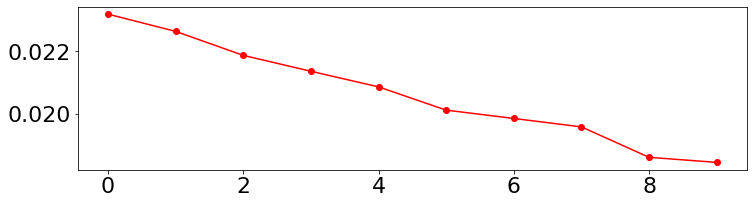

In [255]:
from sklearn.decomposition import PCA
n_components = 10
pca = PCA(copy=True, iterated_power='auto', n_components=n_components, random_state=None,
    svd_solver='randomized', tol=0.0, whiten=False).fit(trial_by_vox.T)
plt.plot(pca.explained_variance_ratio_, 'ro-') 
vox_weights = pca.transform(trial_by_vox.T)

In [98]:
class LogLike(tt.Op):

    """
    Specify what type of object will be passed and returned to the Op when it is
    called. In our case we will be passing it a vector of values (the parameters
    that define our model) and returning a single "scalar" value (the
    log-likelihood)
    """
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that our function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta, = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta, self.x, self.data, self.sigma)

        outputs[0][0] = np.array(logl) # output the log-likelihood

In [126]:
def my_model(theta, x):
    m, c = theta
    return m*x + c

def my_loglike(theta, x, data, sigma):
    model = my_model(theta, x)
    return -(0.5/sigma**2)*np.sum((data - model)**2)

In [129]:
# set up our data
N = 10  # number of data points
sigma = 1.  # standard deviation of noise
x = np.linspace(0., 9., N)

mtrue = 0.4  # true gradient
ctrue = 3.   # true y-intercept

truemodel = my_model([mtrue, ctrue], x)

# make data
np.random.seed(716742)  # set random seed, so the data is reproducible each time
data = sigma*np.random.randn(N) + truemodel

In [130]:
# create our Op
logl = LogLike(my_loglike, data, x, sigma)

# use PyMC3 to sampler from log-likelihood
with pm.Model():
    # uniform priors on m and c
    m = pm.Uniform('m', lower=-10., upper=10.)
    c = pm.Uniform('c', lower=-10., upper=10.)

    # convert m and c to a tensor vector
    theta = tt.as_tensor_variable([m, c])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})

    trace = pm.sample(3000,tune=1000,discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [c]
>Slice: [m]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:11<00:00, 697.79draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [131]:
display(pm.summary(trace))
print(mtrue)
print(ctrue)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
m,0.388004,0.074880,0.002281,0.242144,0.532786,1021.149703,1.001330
c,2.918475,0.401593,0.012390,2.118112,3.681680,1037.491738,1.001011


0.4
3.0


In [9]:
# define a theano Op for our likelihood function
class LogLikeWithGrad(tt.Op):

    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

        # initialise the gradient Op (below)
        self.logpgrad = LogLikeGrad(self.likelihood, self.data, self.x, self.sigma)

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta, = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta, self.x, self.data, self.sigma)

        outputs[0][0] = np.array(logl) # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        theta, = inputs  # our parameters
        return [g[0]*self.logpgrad(theta)]

class LogLikeGrad(tt.Op):

    """
    This Op will be called with a vector of values and also return a vector of
    values - the gradients in each dimension.
    """
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        theta, = inputs

        # define version of likelihood function to pass to derivative function
        def lnlike(values):
            return self.likelihood(values, self.x, self.data, self.sigma)

        # calculate gradients
        grads = gradients(theta, lnlike)

        outputs[0][0] = grads

In [1190]:
# create our Op
logl = LogLikeWithGrad(my_loglike, data, x, sigma)

# use PyMC3 to sampler from log-likelihood
with pm.Model():
    # uniform priors on m and c
    m = pm.Uniform('m', lower=-10., upper=10.)
    c = pm.Uniform('c', lower=-10., upper=10.)

    # convert m and c to a tensor vector
    theta = tt.as_tensor_variable([m, c])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})

    trace = pm.sample(3000,tune=1000,discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, m]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:17<00:00, 457.01draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [1191]:
display(pm.summary(trace))
print(mtrue)
print(ctrue)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
m,0.391956,0.11177,0.002823,0.176704,0.618682,1578.978482,1.002510
c,2.899666,0.59664,0.014997,1.765798,4.109932,1493.948626,1.003152


0.4
3.0


In [22]:
# test the gradient Op by direct call
theano.config.compute_test_value = "ignore"
theano.config.exception_verbosity = "high"

var = tt.dvector()
test_grad_op = LogLikeGrad(my_loglike, data, x, sigma)
test_grad_op_func = theano.function([var], test_grad_op(var))

print(mtrue,ctrue,'\n')
print(test_grad_op_func([mtrue, ctrue]))
print('\n')
print(test_grad_op_func([mtrue+.001, ctrue]))
print(test_grad_op_func([mtrue+.05, ctrue]))
print(test_grad_op_func([mtrue+.1, ctrue]))
print('\n')
print(test_grad_op_func([mtrue, ctrue+.1]))
print(test_grad_op_func([mtrue, ctrue+.4]))
print(test_grad_op_func([mtrue, ctrue+1]))

0.4 3.0 

[-7.17656625 -1.39486358]


[-7.46156625 -1.43986358]
[-21.42656625  -3.64486358]
[-35.67656625  -5.89486358]


[-11.67656625  -2.39486358]
[-25.17656625  -5.39486358]
[-52.17656625 -11.39486358]


In [297]:
def pseudo_loglike(theta,basis_points,channel_sd,trial_features,trial_by_vox):
    sh = theta
#     sh, sd = theta
    maes = auto_recon(basis_points+sh,channel_sd*vox_sd_mu,trial_features,trial_by_vox)
    return -np.sum(maes**3)

# create our Op
logl = LogLike(pseudo_loglike,basis_points,channel_sd,trial_features,trial_by_vox)

# test the gradient Op by direct call
theano.config.compute_test_value = "ignore"
theano.config.exception_verbosity = "high"

var = tt.dvector()
test_grad_op = LogLikeGrad(pseudo_loglike,basis_points,channel_sd,trial_features,trial_by_vox)
test_grad_op_func = theano.function([var], test_grad_op(var))

print(true_sh,'\n')
print(test_grad_op_func([true_sh]))
print(test_grad_op_func([15]))
print(test_grad_op_func([25]))

20 

[-50.59712737]
[317.59510246]
[-92.7854558]


In [ ]:
def pseudo_loglike(theta,basis_points,channel_sd,trial_features,trial_by_vox):
    sd = theta
#     sh, sd = theta
    maes = auto_recon(basis_points+20,channel_sd*sd,trial_features,trial_by_vox)
    return -np.sum(maes**3)

# create our Op
logl = LogLike(pseudo_loglike,basis_points,channel_sd,trial_features,trial_by_vox)

# test the gradient Op by direct call
theano.config.compute_test_value = "ignore"
theano.config.exception_verbosity = "high"

var = tt.dvector()
test_grad_op = LogLikeGrad(pseudo_loglike,basis_points,channel_sd,trial_features,trial_by_vox)
test_grad_op_func = theano.function([var], test_grad_op(var))

print(vox_mu_sd,'\n')
print(test_grad_op_func([vox_mu_sd]))
print(test_grad_op_func([20]))
print(test_grad_op_func([26]))

In [14]:
# test the gradient Op by direct call
theano.config.compute_test_value = "ignore"
theano.config.exception_verbosity = "high"

var = tt.dvector()
test_grad_op = LogLikeGrad(my_loglike, data, x, sigma)
test_grad_op_func = theano.function([var], test_grad_op(var))
grad_vals = test_grad_op_func([mtrue, ctrue])

print('Gradient returned by "LogLikeGrad": {}'.format(grad_vals))

# test the gradient called through LogLikeWithGrad
test_gradded_op = LogLikeWithGrad(my_loglike, data, x, sigma)
test_gradded_op_grad = tt.grad(test_gradded_op(var), var)
test_gradded_op_grad_func = theano.function([var], test_gradded_op_grad)
grad_vals_2 = test_gradded_op_grad_func([mtrue, ctrue])

print('Gradient returned by "LogLikeWithGrad": {}'.format(grad_vals_2))

# test the gradient that PyMC3 uses for the Normal log likelihood
test_model = pm.Model()
with test_model:
    m = pm.Uniform('m', lower=-10., upper=10.)
    c = pm.Uniform('c', lower=-10., upper=10.)

    pm.Normal('likelihood', mu=(m*x + c), sigma=sigma, observed=data)

    gradfunc = test_model.logp_dlogp_function([m, c], dtype=None)
    gradfunc.set_extra_values({'m_interval__': mtrue, 'c_interval__': ctrue})
    grad_vals_pymc3 = gradfunc(np.array([mtrue, ctrue]))[1]  # get dlogp values

print('Gradient returned by PyMC3 "Normal" distribution: {}'.format(grad_vals_pymc3))

Gradient returned by "LogLike": -1.3249385728387384
Gradient returned by "LogLikeWithGrad": [-7.17656625 -1.39486358]
Gradient returned by PyMC3 "Normal" distribution: [-7.17656625 -1.39486358]
